<a href="https://colab.research.google.com/github/dornercr/INFO371/blob/main/INFO371_Week4_Community_Donation_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Community Donation Tracking: A Data Science Demonstration

## Section 1: Introduction
This notebook illustrates a complete workflow for analyzing and modeling a **Community Donation** dataset:

1. (Optional) Generate a synthetic dataset.  
2. Load and inspect the data.  
3. Visualize basic distributions and correlations.  
4. Split into train and test sets.  
5. Create a boolean target (`GroupAHasMore`).  
6. One-hot encode `GroupA`.  
7. Train a decision tree (5-fold cross validation).  
8. Add new features (`GroupAHadMoreLast`, `GroupBHadMoreLast`) and retrain.  
9. Train a random forest.  
10. Perform a grid search for hyperparameter tuning.  
11. Interpret results via a confusion matrix and feature importances.  
12. Evaluate on the test set.  
13. Conclude with final observations.

We use **volunteer group donations** (rather than a sports dataset), but the data science steps are identical to typical classification tasks.

## Section 2: (Optional) Generate Synthetic Data
Run this cell to create `community_donations_2024.csv` in your working directory. If you already have data, skip this step.

In [16]:
import pandas as pd
import numpy as np
import random

# Fix random seed for reproducibility
np.random.seed(2027)
random.seed(2027)

num_events = 10000

# Various volunteer groups
groups = [
    "FoodBankHeroes", "ClothesForAll", "BookDriveCo", "MedSupplyTeam",
    "CleanWaterOrg", "GreenPlanetCrew", "YouthAidGroup", "HousingHelpers"
]

# Generate random dates in 2024
date_range = pd.date_range(start="2024-02-01", periods=num_events, freq="D")
chosen_dates = np.random.choice(date_range, size=num_events, replace=False)

# Random start times
start_times = [
    f"{random.randint(1,12)}:{random.randint(0,59):02d} {'AM' if random.randint(0,1) == 0 else 'PM'}"
    for _ in range(num_events)
]

# Assign GroupA and GroupB
groupA = [random.choice(groups) for _ in range(num_events)]
groupB = [random.choice(groups) for _ in range(num_events)]
for i in range(num_events):
    while groupB[i] == groupA[i]:
        groupB[i] = random.choice(groups)

# Random donation amounts
donationA = np.random.randint(100, 501, size=num_events)
donationB = np.random.randint(100, 501, size=num_events)

# Some placeholders
misc1 = ["Placeholder1" for _ in range(num_events)]
misc2 = ["Placeholder2" for _ in range(num_events)]

attendance = np.random.randint(10, 200, size=num_events)
logs   = ["-" for _ in range(num_events)]
venues = [f"CommunityCenter_{random.randint(1,3)}" for _ in range(num_events)]
notes  = ["" for _ in range(num_events)]

df_community = pd.DataFrame({
    "Date": chosen_dates,
    "StartTime": start_times,
    "GroupA": groupA,
    "DonationA": donationA,
    "GroupB": groupB,
    "DonationB": donationB,
    "MiscCol1": misc1,
    "MiscCol2": misc2,
    "Attendance": attendance,
    "Log": logs,
    "Venue": venues,
    "Notes": notes
})

# Sort by date
df_community = df_community.sort_values("Date").reset_index(drop=True)
df_community.to_csv("community_donations_2024.csv", index=False)
print("Synthetic dataset 'community_donations_2024.csv' created!")
df_community.head(10)

Synthetic dataset 'community_donations_2024.csv' created!


,Date,StartTime,GroupA,DonationA,GroupB,DonationB,MiscCol1,MiscCol2,Attendance,Log,Venue,Notes
0,2024-02-01,6:04 AM,MedSupplyTeam,442,GreenPlanetCrew,206,Placeholder1,Placeholder2,158,-,CommunityCenter_2,
1,2024-02-02,12:33 AM,HousingHelpers,248,BookDriveCo,373,Placeholder1,Placeholder2,128,-,CommunityCenter_1,
2,2024-02-03,7:32 AM,GreenPlanetCrew,108,HousingHelpers,427,Placeholder1,Placeholder2,129,-,CommunityCenter_1,
3,2024-02-04,2:37 PM,ClothesForAll,249,FoodBankHeroes,367,Placeholder1,Placeholder2,158,-,CommunityCenter_2,
4,2024-02-05,12:48 PM,MedSupplyTeam,211,CleanWaterOrg,391,Placeholder1,Placeholder2,45,-,CommunityCenter_1,
5,2024-02-06,3:18 PM,YouthAidGroup,144,FoodBankHeroes,475,Placeholder1,Placeholder2,121,-,CommunityCenter_1,
6,2024-02-07,2:49 AM,YouthAidGroup,382,BookDriveCo,157,Placeholder1,Placeholder2,103,-,CommunityCenter_1,
7,2024-02-08,5:07 AM,CleanWaterOrg,163,HousingHelpers,454,Placeholder1,Placeholder2,79,-,CommunityCenter_3,
8,2024-02-09,5:38 AM,GreenPlanetCrew,382,BookDriveCo,424,Placeholder1,Placeholder2,122,-,CommunityCenter_1,
9,2024-02-10,9:02 AM,FoodBankHeroes,444,BookDriveCo,206,Placeholder1,Placeholder2,109,-,CommunityCenter_1,


## Section 3: Data Loading and Initial Inspection
Here we load the CSV file, parse the date column, and examine the first few rows.

In [17]:
df = pd.read_csv("community_donations_2024.csv")
df["Date"] = pd.to_datetime(df["Date"])

print("DataFrame shape:", df.shape)
df.head()

DataFrame shape: (10000, 12)


,Date,StartTime,GroupA,DonationA,GroupB,DonationB,MiscCol1,MiscCol2,Attendance,Log,Venue,Notes
0,2024-02-01,6:04 AM,MedSupplyTeam,442,GreenPlanetCrew,206,Placeholder1,Placeholder2,158,-,CommunityCenter_2,NaN
1,2024-02-02,12:33 AM,HousingHelpers,248,BookDriveCo,373,Placeholder1,Placeholder2,128,-,CommunityCenter_1,NaN
2,2024-02-03,7:32 AM,GreenPlanetCrew,108,HousingHelpers,427,Placeholder1,Placeholder2,129,-,CommunityCenter_1,NaN
3,2024-02-04,2:37 PM,ClothesForAll,249,FoodBankHeroes,367,Placeholder1,Placeholder2,158,-,CommunityCenter_2,NaN
4,2024-02-05,12:48 PM,MedSupplyTeam,211,CleanWaterOrg,391,Placeholder1,Placeholder2,45,-,CommunityCenter_1,NaN


## Section 4: Basic Data Exploration / Visualizations
We can visualize distributions and correlations to better understand the dataset before modeling.

### 4.1 Distribution of DonationA vs. DonationB

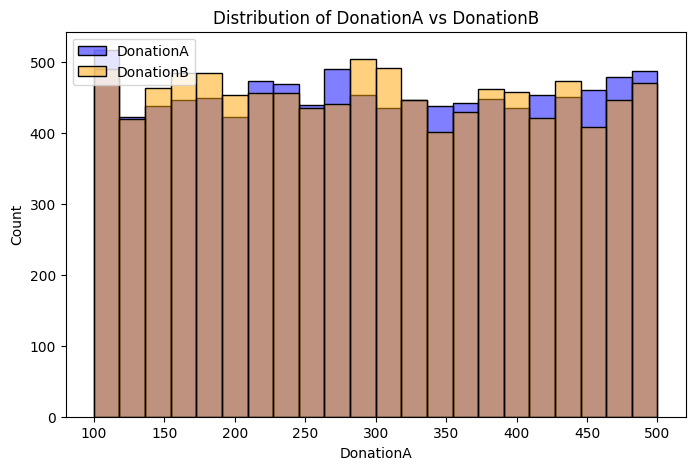

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(data=df, x="DonationA", color='blue', alpha=0.5, label="DonationA")
sns.histplot(data=df, x="DonationB", color='orange', alpha=0.5, label="DonationB")
plt.title("Distribution of DonationA vs DonationB")
plt.legend()
plt.show()

### 4.2 Correlation Heatmap
We only have a few numeric columns (DonationA, DonationB, Attendance), so let's see if they're correlated.

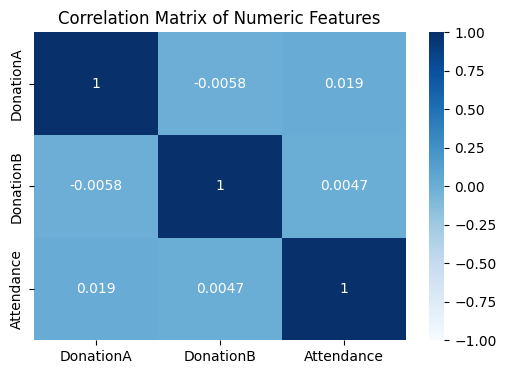

In [19]:
numeric_cols = ["DonationA", "DonationB", "Attendance"]
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

## Section 5: Train/Test Split
We split the dataset into training and test subsets. We'll do an 80/20 split without shuffling for demonstration.

In [20]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 8000
Test set size: 2000


## Section 6: Feature Engineering (Create Target)
We define `GroupAHasMore` as `True` if `DonationA` > `DonationB`, else `False`.

In [21]:
train_df["GroupAHasMore"] = train_df["DonationA"] > train_df["DonationB"]
test_df["GroupAHasMore"]  = test_df["DonationA"]  > test_df["DonationB"]

train_df[["DonationA", "DonationB", "GroupAHasMore"]].head()

,DonationA,DonationB,GroupAHasMore
0,442,206,True
1,248,373,False
2,108,427,False
3,249,367,False
4,211,391,False


## Section 7: Feature Engineering (One-Hot Encoding)
We'll treat `GroupA` as a categorical variable and one-hot encode it.

In [32]:
train_groupA_ohe = pd.get_dummies(train_df["GroupA"], prefix="G_A")
test_groupA_ohe  = pd.get_dummies(test_df["GroupA"], prefix="G_A")

# Align columns
test_groupA_ohe, train_groupA_ohe = test_groupA_ohe.align(train_groupA_ohe, join='left', axis=1)
test_groupA_ohe.fillna(0, inplace=True)

train_groupA_ohe.head()

,G_A_BookDriveCo,G_A_CleanWaterOrg,G_A_ClothesForAll,G_A_FoodBankHeroes,G_A_GreenPlanetCrew,G_A_HousingHelpers,G_A_MedSupplyTeam,G_A_YouthAidGroup
0,False,False,False,False,False,False,True,False
1,False,False,False,False,False,True,False,False
2,False,False,False,False,True,False,False,False
3,False,False,True,False,False,False,False,False
4,False,False,False,False,False,False,True,False


## Section 8: Model 1 - Decision Tree (One-Hot Only)
We'll train a decision tree using just the identity of `GroupA` (via one-hot). We'll use 5-fold cross validation on the training set.

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

X_train_1 = train_groupA_ohe
y_train_1 = train_df["GroupAHasMore"]

clf_tree_1 = DecisionTreeClassifier(random_state=42)
scores_1 = cross_val_score(clf_tree_1, X_train_1, y_train_1, cv=5, scoring='accuracy')
print("Decision Tree (GroupA only) CV accuracy:", np.mean(scores_1))

Decision Tree (GroupA only) CV accuracy: 0.505875


## Section 9: Feature Engineering - "GroupAHadMoreLast" and "GroupBHadMoreLast"
We track whether each group had a higher donation amount in its **previous** event. We'll do this for the training set in chronological order, then continue for the test set.

In [34]:
# Sort train by Date
train_df = train_df.sort_values("Date").reset_index(drop=True)

# Dictionary: group_name -> bool (did they have more last time?)
group_last_more = {}
A_prev_list = []
B_prev_list = []

for idx, row in train_df.iterrows():
    A = row["GroupA"]
    B = row["GroupB"]

    A_prev_win = group_last_more.get(A, False)
    B_prev_win = group_last_more.get(B, False)

    A_prev_list.append(int(A_prev_win))
    B_prev_list.append(int(B_prev_win))

    # Update based on current event
    if row["GroupAHasMore"]:
        group_last_more[A] = True
        group_last_more[B] = False
    else:
        group_last_more[A] = False
        group_last_more[B] = True

train_df["GroupAHadMoreLast"] = A_prev_list
train_df["GroupBHadMoreLast"] = B_prev_list

# Now do the same for the test set, continuing group_last_more
test_df = test_df.sort_values("Date").reset_index(drop=True)
A_test_list = []
B_test_list = []

for idx, row in test_df.iterrows():
    A = row["GroupA"]
    B = row["GroupB"]
    A_prev_win = group_last_more.get(A, False)
    B_prev_win = group_last_more.get(B, False)

    A_test_list.append(int(A_prev_win))
    B_test_list.append(int(B_prev_win))

    # Update after seeing this event
    if row["GroupAHasMore"]:
        group_last_more[A] = True
        group_last_more[B] = False
    else:
        group_last_more[A] = False
        group_last_more[B] = True

test_df["GroupAHadMoreLast"] = A_test_list
test_df["GroupBHadMoreLast"] = B_test_list

train_df.head(8)

,Date,StartTime,GroupA,DonationA,GroupB,DonationB,MiscCol1,MiscCol2,Attendance,Log,Venue,Notes,GroupAHasMore,GroupAHadMoreLast,GroupBHadMoreLast
0,2024-02-01,6:04 AM,MedSupplyTeam,442,GreenPlanetCrew,206,Placeholder1,Placeholder2,158,-,CommunityCenter_2,NaN,True,0,0
1,2024-02-02,12:33 AM,HousingHelpers,248,BookDriveCo,373,Placeholder1,Placeholder2,128,-,CommunityCenter_1,NaN,False,0,0
2,2024-02-03,7:32 AM,GreenPlanetCrew,108,HousingHelpers,427,Placeholder1,Placeholder2,129,-,CommunityCenter_1,NaN,False,0,0
3,2024-02-04,2:37 PM,ClothesForAll,249,FoodBankHeroes,367,Placeholder1,Placeholder2,158,-,CommunityCenter_2,NaN,False,0,0
4,2024-02-05,12:48 PM,MedSupplyTeam,211,CleanWaterOrg,391,Placeholder1,Placeholder2,45,-,CommunityCenter_1,NaN,False,1,0
5,2024-02-06,3:18 PM,YouthAidGroup,144,FoodBankHeroes,475,Placeholder1,Placeholder2,121,-,CommunityCenter_1,NaN,False,0,1
6,2024-02-07,2:49 AM,YouthAidGroup,382,BookDriveCo,157,Placeholder1,Placeholder2,103,-,CommunityCenter_1,NaN,True,0,1
7,2024-02-08,5:07 AM,CleanWaterOrg,163,HousingHelpers,454,Placeholder1,Placeholder2,79,-,CommunityCenter_3,NaN,False,1,1


## Section 10: Model 2 - Decision Tree with New Features
We now combine the **GroupA** one-hot columns and the new columns `GroupAHadMoreLast`, `GroupBHadMoreLast`.

In [35]:
X_train_2 = pd.concat([
    train_groupA_ohe,
    train_df[["GroupAHadMoreLast", "GroupBHadMoreLast"]]
], axis=1)

y_train_2 = train_df["GroupAHasMore"]

clf_tree_2 = DecisionTreeClassifier(random_state=42)
scores_2 = cross_val_score(clf_tree_2, X_train_2, y_train_2, cv=5, scoring='accuracy')
print("Decision Tree (OHE + hadMoreLast) CV accuracy:", np.mean(scores_2))

Decision Tree (OHE + hadMoreLast) CV accuracy: 0.49700000000000005


## Section 11: Model 3 - Random Forest (Default Settings)
We'll use the same features (one-hot + had-more-last) in a random forest classifier.

In [36]:
from sklearn.ensemble import RandomForestClassifier

clf_rf_default = RandomForestClassifier(random_state=42)

scores_rf_default = cross_val_score(clf_rf_default, X_train_2, y_train_2, cv=5, scoring='accuracy')
print("Random Forest (all features, default) CV accuracy:", np.mean(scores_rf_default))

Random Forest (all features, default) CV accuracy: 0.495


## Section 12: Grid Search (Random Forest)
We tune `max_features`, `n_estimators`, and `min_samples_leaf` using 5-fold cross validation.

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_features": [0.5, "sqrt", "log2"],
    "n_estimators": [50, 100, 200],
    "min_samples_leaf": [1, 2, 5]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_2, y_train_2)


print("Best params:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

print("test_X.shape:", test_X.shape)
print("test_y.shape:", test_y.shape)

best_rf_model = grid_search.best_estimator_
best_rf_model

Best params: {'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 200}
Best CV score: 0.49824999999999997
test_X.shape: (4000, 10)
test_y.shape: (2000,)


RandomForestClassifier(max_features=0.5, n_estimators=200, random_state=42)

## Section 13: Model Interpretation
### 13.1 Confusion Matrix on the Training Set (or a Validation Split)
We can see how predictions match actuals. (We'll do final test set evaluation in the next step.)

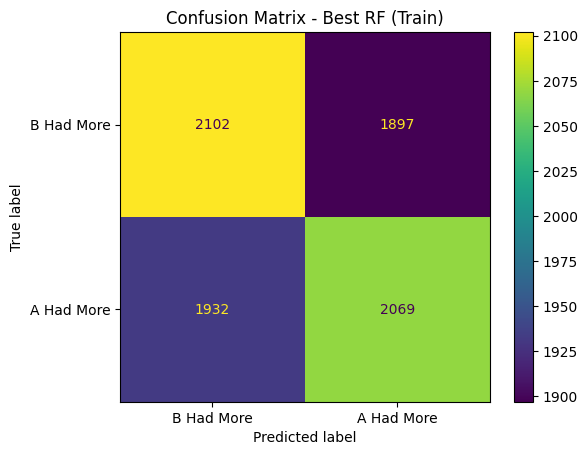

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# For demonstration, let's do a quick train set predict to see how well it fits.
best_rf_model.fit(X_train_2, y_train_2)
y_train_pred = best_rf_model.predict(X_train_2)

cm = confusion_matrix(y_train_2, y_train_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["B Had More", "A Had More"])
disp.plot()
disp.ax_.set_title("Confusion Matrix - Best RF (Train)")
plt.show()

### 13.2 Feature Importances
We can see which columns (one-hot or had-more-last) were most important to the random forest.

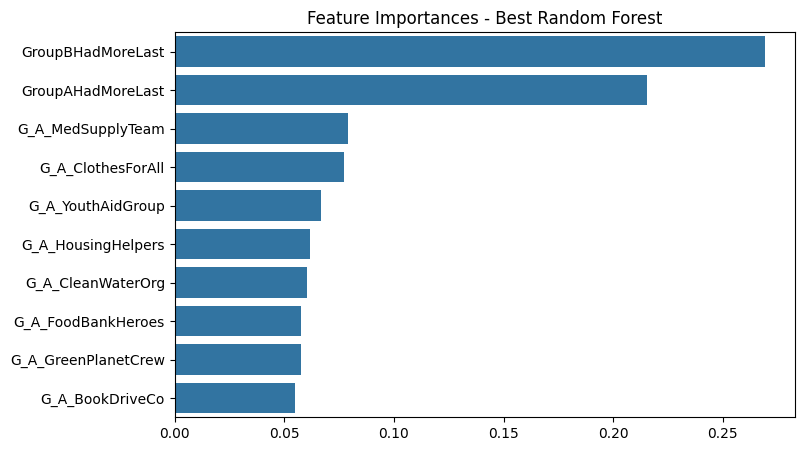

In [39]:
import numpy as np

feature_names = list(X_train_2.columns)
importances = best_rf_model.feature_importances_

# Sort by importance, descending
sorted_idx = np.argsort(importances)[::-1]

top_n = 10  # if you have many OHE columns, limit to top 10
top_idx = sorted_idx[:top_n]

plt.figure(figsize=(8,5))
sns.barplot(x=importances[top_idx], y=np.array(feature_names)[top_idx], orient='h')
plt.title("Feature Importances - Best Random Forest")
plt.show()

## Section 14: Evaluate on the Test Set
Finally, we see how the **best model** from grid search performs on unseen data.

Test accuracy: 0.498


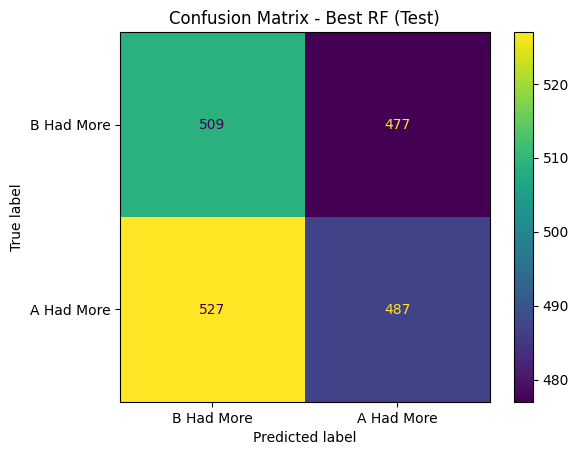

In [40]:
# Prepare test features
test_X = pd.concat([
    test_groupA_ohe,
    test_df[["GroupAHadMoreLast", "GroupBHadMoreLast"]]
], axis=1)
test_y = test_df["GroupAHasMore"]

# Evaluate test accuracy
test_accuracy = best_rf_model.score(test_X, test_y)
print("Test accuracy:", test_accuracy)

# Confusion matrix on test set
y_test_pred = best_rf_model.predict(test_X)
cm_test = confusion_matrix(test_y, y_test_pred, labels=[False, True])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["B Had More", "A Had More"])
disp_test.plot()
disp_test.ax_.set_title("Confusion Matrix - Best RF (Test)")
plt.show()

## Section 15: Conclusion
In this notebook, we demonstrated:
- Generating or loading a **community donation** dataset.
- Splitting data into **train** and **test** sets.
- Creating a **boolean target** (`GroupAHasMore`).
- **One-hot encoding** a categorical column.
- Training a **decision tree** with 5-fold cross validation.
- Adding new features (`GroupAHadMoreLast` and `GroupBHadMoreLast`).
- Training a **random forest**, then **tuning** it with grid search.
- Interpreting results via **confusion matrix** and **feature importances**.
- Checking final performance on the **test** set.

If the test accuracy is low, it may reflect:
1. **Synthetic randomness** in the data.
2. **Small dataset** (only 100 events).
3. **No real pattern** to learn.

Nevertheless, the **workflow** is correct and can be applied to **any** domain with a similar structure. Consider increasing data size or using real-world data to see if accuracy improves!